# 나이브베이즈 스팸메일 구분
- Enron 이메일 데이터 개요
- 3672개의 정상 메일, 1500개의 스팸메일로 구성
- ham : 정상메일이 담긴 폴더
- spam : 스팸 메일이 담긴 폴더

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

In [2]:
emails, labels = [], []

paths = ["D:/Workspace/연습폴더/실습데이터_파이썬 머신러닝/enron1/spam/", "D:/Workspace/연습폴더/실습데이터_파이썬 머신러닝/enron1/ham/"]

for path in paths:
    for filename in glob.glob(os.path.join(path, '*.txt')):
        with open(filename, 'r', encoding="ISO-8859-1") as file:
            emails.append(file.read())
            if path.endswith("spam/"):
                labels.append(1)
            else:
                labels.append(0)

print(np.unique(labels, return_counts=True))

(array([0, 1]), array([3672, 1500], dtype=int64))


In [3]:
# 숫자 구두점 사람이름 제거
import nltk
nltk.download('names')
# 이름과 관련된
nltk.download('wordnet')
# 워드넷 파일 다운

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\DQ\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DQ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from nltk.corpus import names
# corpus(말뭉치)중 이름
from nltk.stem import WordNetLemmatizer
# stem(어근) 중 단어 분류기 - 불용어처리

In [5]:
all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

In [6]:
cleaned_emails = []
for email in emails:
    cleaned_emails.append(' '.join([lemmatizer.lemmatize(word.lower())
    # 리스트컴프레션 하여 원소로 사용해 join이 이루어짐, lemmatizer: 단어가 동사 품사라는 사실을 확인가능
                                    for word in email.split()
                                    # 0 email.을 분리해 검사함
                                    if word.isalpha()
                                    # 2 is alpha 알파벳인지 검사
                                    and word not in all_names]))
                                    # 1 그워드가 네임스에 들어가지않으면
cleaned_emails[0]

'dobmeos with hgh my energy level ha gone up stukm introducing doctor formulated hgh human growth hormone also called hgh is referred to in medical science a the master hormone it is very plentiful when we are young but near the age of twenty one our body begin to produce le of it by the time we are forty nearly everyone is deficient in hgh and at eighty our production ha normally diminished at least advantage of hgh increased muscle strength loss in body fat increased bone density lower blood pressure quickens wound healing reduces cellulite improved vision wrinkle disappearance increased skin thickness texture increased energy level improved sleep and emotional stability improved memory and mental alertness increased sexual potency resistance to common illness strengthened heart muscle controlled cholesterol controlled mood swing new hair growth and color restore read more at this website unsubscribe'

In [7]:
# 불용어 제거와 단어의 출현 빈도 특징을 추출
from sklearn.feature_extraction.text import CountVectorizer
# CountVectorizer : 단어 출현 빈도와 관련돼 있는 작업을 수행해주는 변환기
vectorizer = CountVectorizer(stop_words='english', max_features=500)
term_docs = vectorizer.fit_transform(cleaned_emails)
print(term_docs[0])

  (0, 125)	2
  (0, 178)	2
  (0, 47)	1
  (0, 497)	1
  (0, 231)	1
  (0, 445)	1
  (0, 345)	1
  (0, 250)	1
  (0, 424)	1
  (0, 285)	1
  (0, 69)	1
  (0, 357)	1
  (0, 481)	1


In [8]:
term_docs
# spars matrix형태 희소행렬

<5172x500 sparse matrix of type '<class 'numpy.int64'>'
	with 113999 stored elements in Compressed Sparse Row format>

In [9]:
term_docs.toarray()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [10]:
feature_names = vectorizer.get_feature_names()
# 500개의 컬럼의 이름 변수에 저장

feature_names[481], feature_names[357], feature_names[125], feature_names[:5]

('website',
 'read',
 'energy',
 ['able', 'access', 'account', 'accounting', 'act'])

In [11]:
len(feature_names)

500

In [12]:
# 훈련데이터와 테스트 데이터의 분리 및 변환
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_emails, labels, test_size=0.3, random_state=35)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3620, 1552, 3620, 1552)

In [14]:
term_docs_train = vectorizer.fit_transform(X_train)
term_docs_test = vectorizer.transform(X_test)

In [15]:
# 모델의 성능 측정 : 정확도, AUC

from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB(alpha=1, fit_prior=True)
                            # 스무딩파라메터 1, 사소한확률 적용
naive_bayes.fit(term_docs_train, y_train)

MultinomialNB(alpha=1)

In [16]:
y_pred = naive_bayes.predict(term_docs_test)
y_pred[:5]

array([0, 0, 0, 1, 0])

In [17]:
np.unique(y_pred, return_counts=True)
# y_pred 빈도 결과 출력

(array([0, 1]), array([1060,  492], dtype=int64))

In [18]:
naive_bayes.score(term_docs_test, y_test)

0.9117268041237113

In [19]:
y_pred_proba = naive_bayes.predict_proba(term_docs_test)
# 스팸분류 0이면 햄 1이면 스팸
y_pred_proba[:5]

array([[1.00000000e+000, 6.08798181e-313],
       [9.27911745e-001, 7.20882550e-002],
       [1.00000000e+000, 1.37875622e-037],
       [2.55081896e-013, 1.00000000e+000],
       [1.00000000e+000, 0.00000000e+000]])

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve

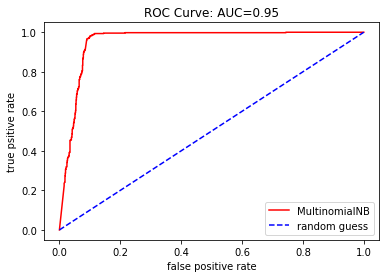

In [21]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])# y_test, 스팸을 선택할 확률만 가져옴
auc = roc_auc_score(y_test, y_pred_proba[:,1])
plt.plot(fpr, tpr, "r-", label='MultinomialNB')
        #x, y, color, 범례
plt.plot([0,1], [0,1], "b--", label='random guess')
        #x, y 의 점선
plt.xlabel("false positive rate")
plt.ylabel("true psitive rate")
plt.title("ROC Curve: AUC={0:.2f}".format(auc))
plt.legend(loc='lower right');

In [22]:
# 나이브 베이즈는 범주형데이터 에서 강력한 성능을 보여줌

In [23]:
# 모델의 성능 개선
from sklearn.model_selection import GridSearchCV

In [24]:
parameters = {
    "alpha": [0.5, 1.0, 1.5, 2.0],
    "fit_prior" : [True, False]
}

In [25]:
grid_search = GridSearchCV(naive_bayes, parameters, n_jobs=-1, cv=10, scoring="roc_auc")
                                                            # 교차검증 10겹, 

In [26]:
grid_search.fit(term_docs_train, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(alpha=1), n_jobs=-1,
             param_grid={'alpha': [0.5, 1.0, 1.5, 2.0],
                         'fit_prior': [True, False]},
             scoring='roc_auc')

In [27]:
grid_search.best_params_

{'alpha': 0.5, 'fit_prior': True}

In [28]:
naive_bayes_best = grid_search.best_estimator_

In [29]:
y_pred = naive_bayes_best.predict(term_docs_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [30]:
naive_bayes_best.score(term_docs_test, y_pred)

1.0

In [31]:
y_pred_proba = naive_bayes_best.predict_proba(term_docs_test)
y_pred_proba[:5]

array([[1.00000000e+00, 0.00000000e+00],
       [9.33961024e-01, 6.60389764e-02],
       [1.00000000e+00, 2.47667385e-39],
       [3.08978789e-14, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00]])

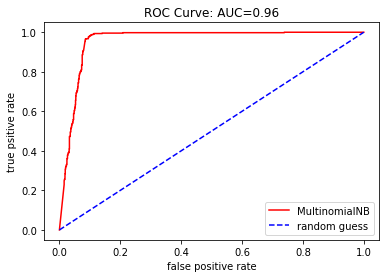

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])# y_test, 스팸을 선택할 확률만 가져옴
auc = roc_auc_score(y_test, y_pred_proba[:,1])
plt.plot(fpr, tpr, "r-", label='MultinomialNB')
        #x, y, color, 범례
plt.plot([0,1], [0,1], "b--", label='random guess')
        #x, y 의 점선
plt.xlabel("false positive rate")
plt.ylabel("true psitive rate")
plt.title("ROC Curve: AUC={0:.2f}".format(auc))
plt.legend(loc='lower right');